In [88]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
def f(x):
    return 3*x**2 - 4*x + 5

In [90]:
f(3.0)

20.0

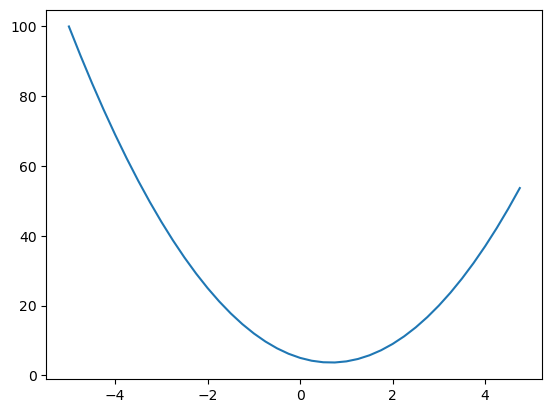

In [91]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [92]:
h = 0.0000001
x = 0.75
(f(x+h)-f(x))/h

0.5000002989419272

In [93]:
#getting more complex
a = 2.0
b = -3.0
c =10
d1 = a*b+c
c += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d1-d2)/h)

d1 4.0
d2 4.000000099999999
slope -0.999999993922529


In [136]:
class Value:
    
    def __init__(self, data, _children = (), _op='', label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda :None
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self): #provides way to print out nice looking expression
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), '*')
        
        def _backward():
            self.grad += other.grad * out.grad
            other.grad += self.grad * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
        
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad
            
            
        out._backward += _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
                             
                
            
        
        
        
   

In [137]:
a = Value(3, label='a')
a+1

Value(data=4)

In [95]:
a = Value(3, label='a')
b = Value(5, label='b')
e = a*b 
e.label= 'e'
c = Value(10, label = 'c')
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f
L.label = 'L'

In [96]:
e.label

'e'

In [97]:
d._prev

{Value(data=10), Value(data=15)}

In [98]:
d._op

'+'

In [99]:
d.label

'd'

In [129]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name= uid + n._op, label= n._op)
            dot.edge(uid+n._op ,uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot
            
        

In [101]:
#adding grads manually
L.grad = 1
f.grad = 25 #df/dL
d.grad = -2
c.grad = -2#dd/dL * dc/dd
e.grad = -2
b.grad = -6#de/dL * de/db
a.grad = -10


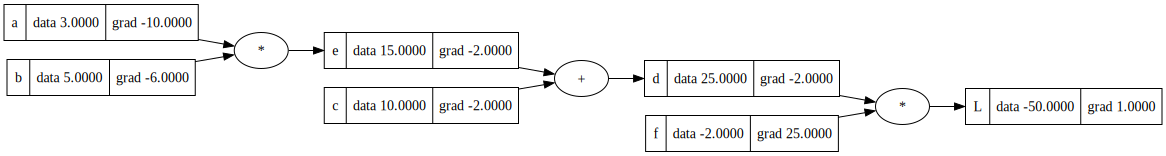

In [102]:
draw_dot(L)

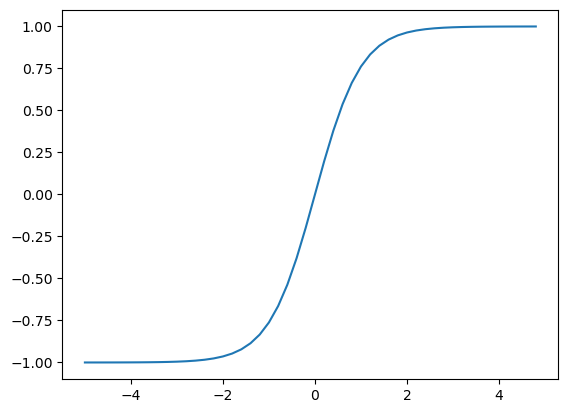

In [103]:
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5,5,.2)))

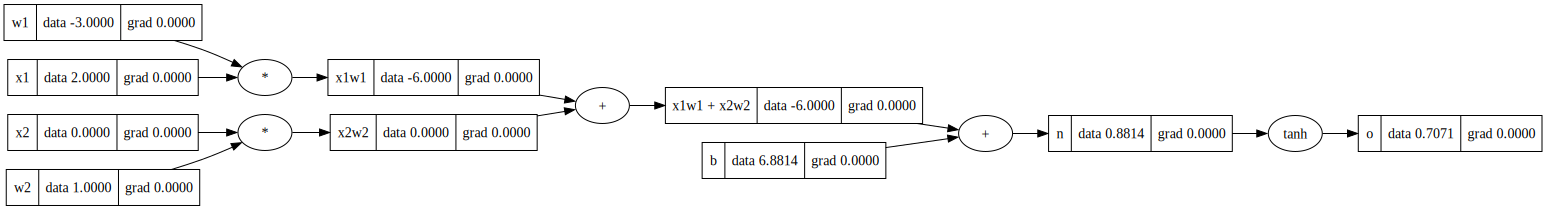

In [130]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88137358701, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label= 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [124]:
o.grad = 1
o._backward()

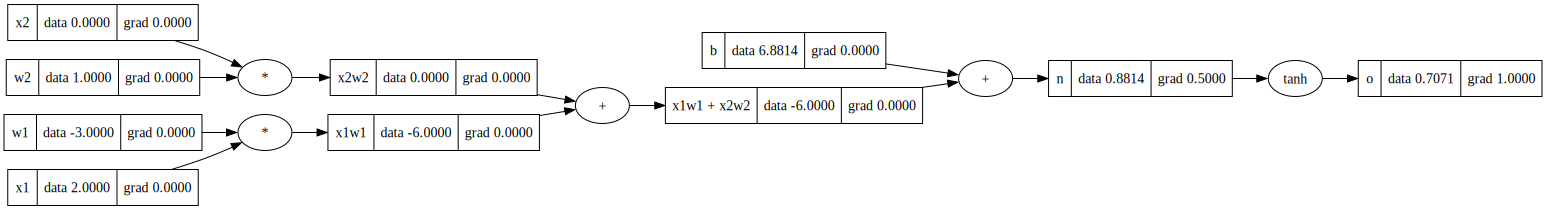

In [125]:
draw_dot(o)

In [108]:
type(n)

__main__.Value

In [127]:
o.grad = 1
n.grad = .5
x1w1x2w2.grad = .5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad =0.5
x2.grad =w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad =w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

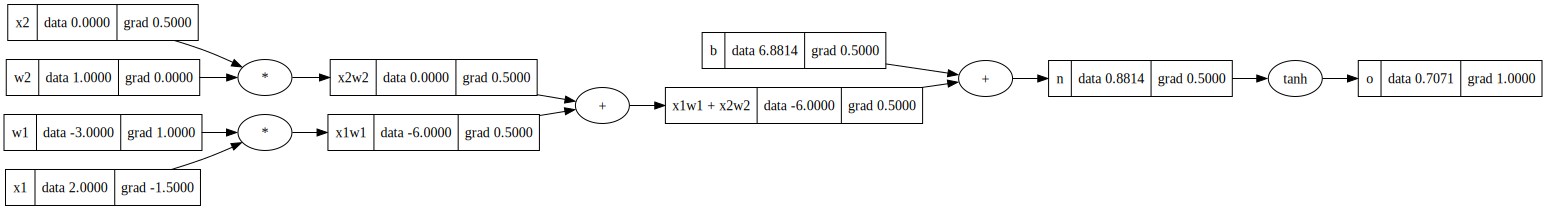

In [128]:
draw_dot(o)

In [131]:
o.backward()

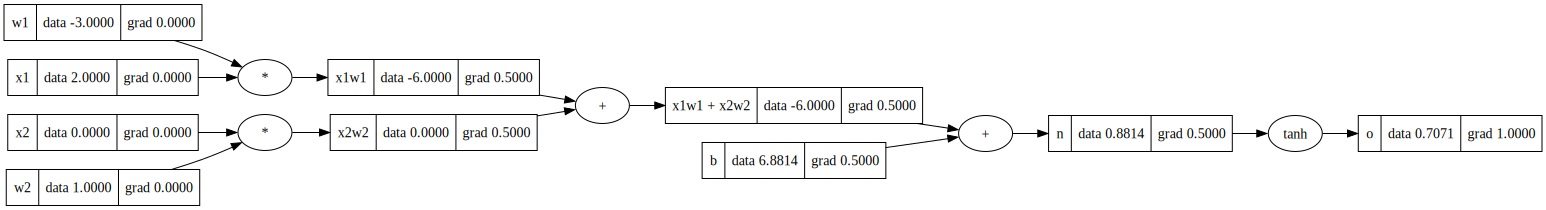

In [132]:
draw_dot(o)